# Binary Anomaly Detection

**Inputs**

The 14 waveform inputs are:

- `A+IGBT-I: current`: Current passing through the IGBT switch of phase A+ in Qa1 ($A$)
- `A+*IGBT-I: current`: Current passing through the IGBT switch of phase A+\* in Qa3 ($A$)
- `B+IGBT-I: current`: Current passing through the IGBT switch of phase B+ in Qb1 ($A$)
- `B+*IGBT-I: current`: Current passing through the IGBT switch of phase B+\* in Qb3 ($A$)
- `C+IGBT-I: current`: Current passing through the IGBT switch of phase C+ in Qc1 ($A$)
- `C+*IGBT-I: current`: Current passing through the IGBT switch of phase C+\* in Qc3 ($A$)
- `A-Flux`: Magnetic flux density for phase A in transformer XA ($-$)
- `B-Flux`: Magnetic flux density for phase B in transformer XB ($-$)
- `C-Flux`: Magnetic flux density for phase C in transformer XC ($-$)
- `Mod-V`: Modulator voltage ($V$)
- `Mod-I`: Modulator current ($A$)
- `CB-I`: Cap bank current ($-$)
- `CB-V`: Cap bank voltage ($V$)
- `DV/DT`: Time derivative change of the Mod\-V voltage ($-$)

**Output**

- `Class_Run`/`Class_Fault`: Whether a waveform is a part of a system fault

This benchmark analyzes a measured dataset originating from [[RPW+22](https://pymaise.readthedocs.io/en/latest/#data-references), [RPW+23](https://pymaise.readthedocs.io/en/latest/#data-references)] for the high voltage converter modulators (HVCM) of the Spallation Neutron Source facility. While this data does not originate from a nuclear power plant, its nature is similar to that found from measured sensor data in nuclear power plants. 

HVCMs are machines powering the linear accelerator klystrons in the accelerator facility. Klystrons produce high-power radio frequency to accelerate negatively charged hydrogen ions. The waveform signals, as shown in the figure below, were collected from the operation of 15 HVCM systems from 2020 to 2022. These datasets contain the waveform signals and the waveform label recorded by the HVCM controller. These binary labels determine if the waveform was collected before a "fault" or "run" (non-fault). Each waveform consists of the 14 signals listed above, the components these originate from in the HVCM are shown in the diagram below the waveform plot. The faults may appear in one or more of these signals, and having one faulty signal is sufficient to label the waveform as faulty. In this benchmark, we ask ML models to correctly classify waveforms from the drift-tube linac (DTL) dataset, one of four datasets provided in [Mendeley](https://data.mendeley.com/datasets/kbbrw99vh8/5) from [[RPW+22](https://pymaise.readthedocs.io/en/latest/#data-references)].

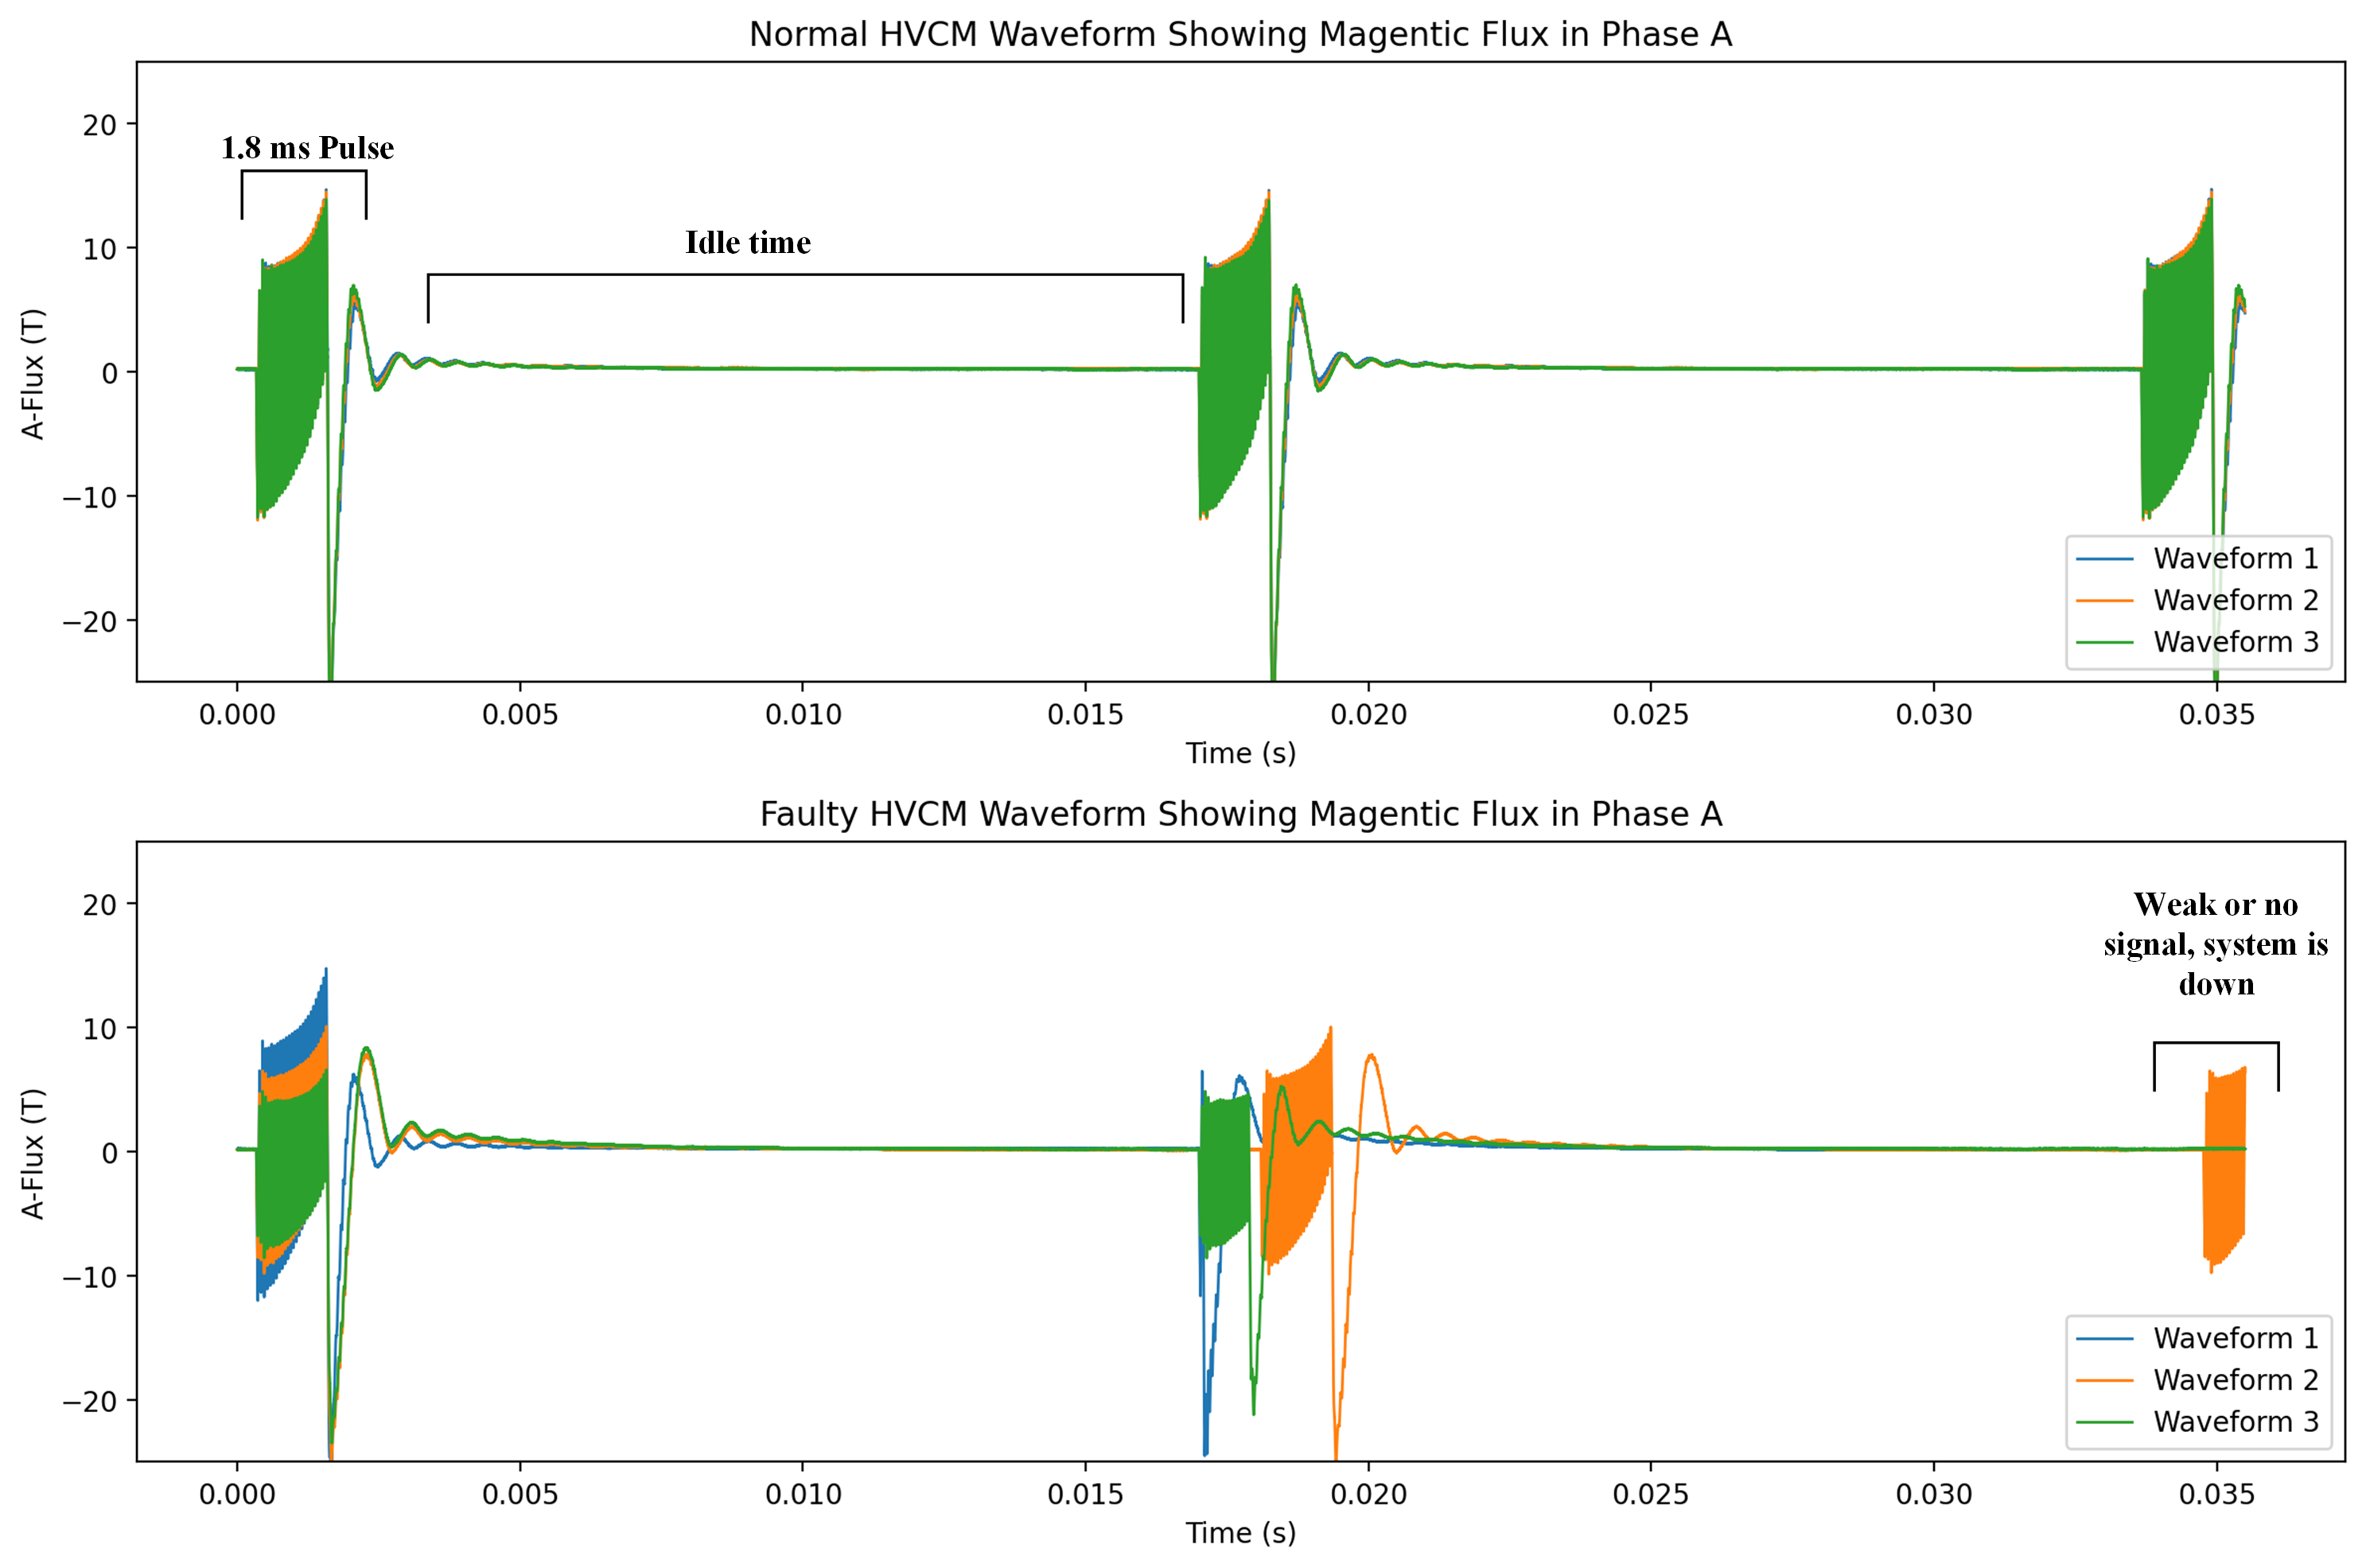
![scheme](supporting/HVCM_schem.png)

## Preprocessing

In the following benchmark, we demonstrate pyMAISE on two shapes of data:
- Case 1: The raw data is kept as is, with an input shape of $(\text{samples}, \text{time steps}, \text{features})$ and output shape of $(\text{samples}, \text{labels})$.
- Case 2: The raw data is stacked following a train/test split to produce an input shape of $(\text{samples}\times \text{time steps}, \text{features})$ and output shape of $(\text{samples} \times \text{time steps}, \text{labels})$ (the labels were propagated out in time for each sample before stacking). We then apply a rolling window with a lookback of 10 to produce an input shape of $(\text{samples} \times \text{time steps} - 9, 10, \text{features})$ and output of $(\text{samples} \times \text{time steps} - 9, 10, \text{labels})$.

The DTL dataset consists of 1077 waveforms, 159 of which are faulty. To make the classifications more balanced and thus reduce the bias against faulty cases, we randomly cut the number of non-faulty samples to 275 so that 37% of the 434 samples were faulty. This distribution is visualized in the frequency plot below. These samples were randomly split into training and testing sets of sizes 303 and 131, respectively. Each sample consists of 14 features, each characterized by 4500 time steps. The output indicates whether the waveform is faulty or non-faulty and is one-hot encoded. Therefore, the final input and output shapes, including both training and testing sets combined, of each case are

- Case 1: input (434, 4500, 14), output (434, 2).
- Case 2: input (1952982, 10, 14), output (1952982, 10, 2)

The inputs of each case were min-max scaled.

![Frequency of positive/negative values in anomaly detection data.](supporting/anomaly/figs/bc1_frequency.png)

## Hyperparameter Tuning

Given the quantity of data and complexity of the neural networks trained here, we hyperparameter-tuned all models separately. The scripts for hyperparameter tuning these models are provided in the `benchmarks/supporting/anomaly/` directory of the [pyMAISE GitHub repository](https://github.com/myerspat/pyMAISE). These scripts include the following:

- `settings.py`: This script includes many of the global variables used in this benchmark and the supporting scripts, including:
  - `input_path`: The path to the raw input data taken from [Mendeley](https://data.mendeley.com/datasets/kbbrw99vh8/5). Note that we do not host this dataset in pyMAISE as its size is rather large.
  - `output_path`: Path to the labels from [Mendeley](https://data.mendeley.com/datasets/kbbrw99vh8/5).
  - `problem_type = mai.ProblemType.CLASSIFICATION`.
  - `data_random_state = 42`: Integer to ensure the data split between Case 1 and 2 is consistent.
  - `verbosity = 3`: Level of output from pyMAISE.
  - `non_faulty_frac = 0.3`: The fraction of "run" or non-faulty data to retain. Non-faulty samples are randomly sampled. Due to the low frequency of "faulty" waveforms, we reduce the total number of "run" waveforms to ensure the models are not overfitting to "run" waveforms.
  - `test_size = 0.3`: The fraction of samples for testing.
- `preprocessing.py`: A preprocessing script that wraps `pyMAISE.datasets.load_anomaly` based on the shape of data we desire (Case 1 or 2); this function is `load_anomaly_data`, and we use it below, too. This function uses the predefined paths in `settings.py` to load and format the HVCM data. Additionally, we provide a wrapper function for `pyMAISE.preprocessing.SplitSequence` called `split_sequence` to utilize pyMAISE-supported functions with the data's format.
- `binary_case_1.py`: The Hyperparameter tuning script for Case 1 includes the hyperparameter tuning spaces for the LSTM and GRU. Both models are tuned with Bayesian search with 50 iterations of a 5-fold time-series cross-validation split. The results are written to a pickle given at `configs/binary_case_1.pkl`.
- `binary_case_2.py`: Hyperparameter tuning script for Case 2, which includes the hyperparameter tuning spaces for the LSTM, GRU, and CNN-LSTM. Both models are tuned with Bayesian search with 50 iterations of a 5-fold time-series cross-validation split. The results are written to a pickle given at `configs/binary_case_2.pkl`.

For the hyperparameter tuning search spaces, please refer to the dictionaries defined in `binary_case_1.py` and `binary_case_2.py`, which are defined in typical pyMAISE format.

## Postprocessing

Below are the results of Cases 1 and 2. We first load the data using the wrapper functions discussed in the previous section and then load the pickle of hyperparameter configurations. These are then trained again in the `pyMAISE.PostProcessor`, and we discuss the result.

In [1]:
# Import other packages
import pickle
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, "supporting/anomaly")

# pyMAISE specific imports
from supporting.anomaly.preprocessing import load_anomaly_data, split_sequences
import supporting.anomaly.settings as anomaly_settings
import pyMAISE as mai

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 12,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

In [2]:
global_settings = mai.init(
    problem_type=anomaly_settings.problem_type,
    random_state=anomaly_settings.random_state,
    cuda_visible_devices="1",  # Use GPU 1
)

## Case 1: 3D Data

We load the DTL dataset using the `load_anomaly_data` wrapper function implemented in `benchmarks/supporting/anomaly/preprocessing.py`. The shapes of train/test input/output sets are shown below.

In [3]:
xtrain, xtest, ytrain, ytest, xscaler = load_anomaly_data(
    global_settings=global_settings,
    stack_series=False,
    multiclass=False,
    test_size=anomaly_settings.test_size,
    non_faulty_frac=anomaly_settings.non_faulty_frac,
    timestep_step=1,
)
mai._try_clear()

print(f"xtrain shape: {xtrain.shape}")
print(f"ytrain shape: {ytrain.shape}")
print(f"xtest shape: {xtest.shape}")
print(f"ytest shape: {ytest.shape}")

xtrain shape: (303, 4500, 14)
ytrain shape: (303, 2)
xtest shape: (131, 4500, 14)
ytest shape: (131, 2)


In [4]:
xtrain

<xarray.DataArray (samples: 303, time steps: 4500, features: 14)>
array([[[0.6017403 , 0.6097828 , 0.80258626, ..., 0.49930644,
         0.9573099 , 0.5035743 ],
        [0.60082346, 0.6097828 , 0.80217534, ..., 0.49930644,
         0.956722  , 0.5073832 ],
        [0.6005178 , 0.61042136, 0.80176437, ..., 0.50022596,
         0.95717424, 0.50484365],
        ...,
        [0.60510194, 0.61201763, 0.80464107, ..., 0.4974674 ,
         0.9204534 , 0.54420173],
        [0.60601896, 0.61297536, 0.8058739 , ..., 0.4974674 ,
         0.92058915, 0.5480083 ],
        [0.60449076, 0.6123369 , 0.8034082 , ..., 0.4974674 ,
         0.9200012 , 0.54674464]],

       [[0.599601  , 0.61042136, 0.8009425 , ..., 0.50022596,
         0.95179266, 0.50611365],
        [0.5992953 , 0.6101021 , 0.8005315 , ..., 0.50068575,
         0.95179266, 0.5035741 ],
        [0.6002122 , 0.6107406 , 0.80135345, ..., 0.50068575,
         0.95147616, 0.507383  ],
...
        [0.60846364, 0.6132947 , 0.80546296, ..., 0.49838698,
         0.8540802 , 0.5353146 ],
        [0.609075  , 0.613614  , 0.80546296, ..., 0.49930644,
         0.85442394, 0.530234  ],
        [0.60846364, 0.6142524 , 0.8042301 , ..., 0.4974674 ,
         0.85442394, 0.5365835 ]],

       [[0.60082346, 0.6107406 , 0.8005315 , ..., 0.50022596,
         0.9526067 , 0.5175401 ],
        [0.60143465, 0.6116984 , 0.8009425 , ..., 0.49838698,
         0.9526067 , 0.5124616 ],
        [0.6005178 , 0.6113791 , 0.80176437, ..., 0.50022596,
         0.95292324, 0.5073831 ],
        ...,
        [0.60296273, 0.6097828 , 0.7997096 , ..., 0.49930644,
         0.9171522 , 0.5353146 ],
        [0.60143465, 0.6101021 , 0.8009425 , ..., 0.49930644,
         0.91688085, 0.53912634],
        [0.6023515 , 0.6101021 , 0.8009425 , ..., 0.4974674 ,
         0.9170165 , 0.5289652 ]]], dtype=float32)
Coordinates:
  * samples     (samples) int64 118 114 140 137 322 332 ... 71 106 270 348 102
  * time steps  (time steps) int64 0 1 2 3 4 5 ... 4494 4495 4496 4497 4498 4499
  * features    (features) <U18 'A+IGBT-I: current' ... 'DV/DT'

In [5]:
ytrain

<xarray.DataArray (samples: 303, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
...
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])
Coordinates:
  * samples   (samples) int64 118 114 140 137 322 332 ... 188 71 106 270 348 102
  * features  (features) object 'Class_Fault' 'Class_Run'

For Case 1, we hyperparameter-tuned the following models:

- Long short-term memory neural network: `LSTM`,
- Gated recurrent unit neural network: `GRU`,

by running `benchmarks/supporting/anomaly/binary_case_1.py`. Below is the convergence plot for the Bayesian search.

![bc1](supporting/anomaly/figs/bc1_convergence.png)

To postprocess these models we can load the pickle found at `benchmarks/supporting/anomaly/configs/binary_case_1.pkl`.

In [6]:
with open("supporting/anomaly/configs/binary_case_1.pkl", "rb") as f:
    configs = pickle.load(f)
mai._try_clear()

### Model Postprocessing

With the hyperparameter configurations and data, we can retrain the models on the whole dataset using the `pyMAISE.PostProcessor`. For both models, we increase the epochs from 7 to 100.

In [7]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest),
    model_configs=[configs],
    new_model_settings={
        "LSTM": {"fitting_params": {"epochs": 100}},
        "GRU": {"fitting_params": {"epochs": 100}},
    },
)

Below are the performance metrics for the two models on this classification problem.

In [8]:
postprocessor.metrics().drop("Parameter Configurations", axis=1)

,Model Types,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
2,LSTM,0.768977,0.768977,0.768977,0.768977,0.755725,0.755725,0.755725,0.755725
4,LSTM,0.745875,0.745875,0.745875,0.745875,0.679389,0.679389,0.679389,0.679389
6,GRU,0.745875,0.745875,0.745875,0.745875,0.679389,0.679389,0.679389,0.679389
5,GRU,0.739274,0.739274,0.739274,0.739274,0.671756,0.671756,0.671756,0.671756
7,GRU,0.739274,0.739274,0.739274,0.739274,0.671756,0.671756,0.671756,0.671756
8,GRU,0.716172,0.716172,0.716172,0.716172,0.671756,0.671756,0.671756,0.671756
9,GRU,0.726073,0.726073,0.726073,0.726073,0.671756,0.671756,0.671756,0.671756
3,LSTM,0.712871,0.712871,0.712871,0.712871,0.618321,0.618321,0.618321,0.618321
0,LSTM,0.656766,0.656766,0.656766,0.656766,0.580153,0.580153,0.580153,0.580153
1,LSTM,0.564356,0.564356,0.564356,0.564356,0.549618,0.549618,0.549618,0.549618


The LSTM outperforms the GRU with a test accuracy close to 0.75. The remaining models overfit the training data. Below, we show the optimal hyperparameters and the network plots for the LSTM and GRU, respectively.

In [9]:
for model in ["LSTM", "GRU"]:
    postprocessor.print_model(model_type=model)
    print()

Model Type: LSTM
  Structural Hyperparameters
    Layer: LSTM_input_0
      units: 51
    Layer: LSTM_0
      units: 25
      activation: tanh
    Layer: LSTM_1
      units: 25
      activation: tanh
    Layer: LSTM_2
      units: 25
      activation: tanh
    Layer: LSTM_3
      units: 25
      activation: tanh
    Layer: LSTM_output_0
      units: 61
      activation: sigmoid
    Layer: Dense_0
      units: 25
    Layer: Dense_1
      units: 25
    Layer: Dense_2
      units: 25
    Layer: Dense_3
      units: 25
    Layer: Dense_output_0
  Compile/Fitting Hyperparameters
    Adam_learning_rate: 3.223746051302877e-05
    Adam_clipnorm: 0.9314610424860413
    Adam_clipvalue: 0.5187788874324804
    batch_size: 8
Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_input_0 (LSTM)         (None, 4500, 51)          13464     
                                                                 


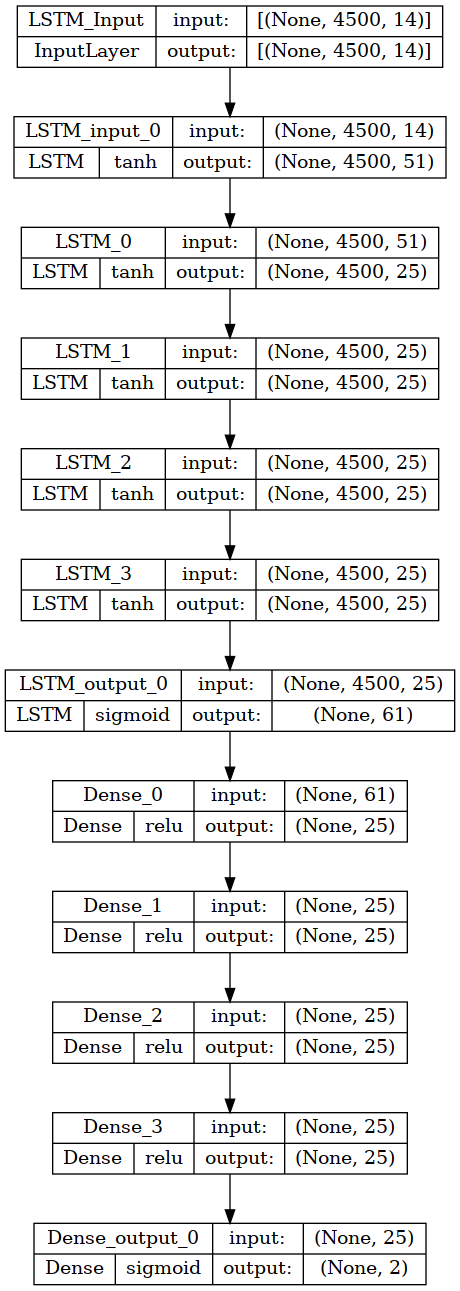

In [10]:
postprocessor.nn_network_plot(
    model_type="LSTM",
    to_file="./supporting/anomaly_lstm_3d.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
)

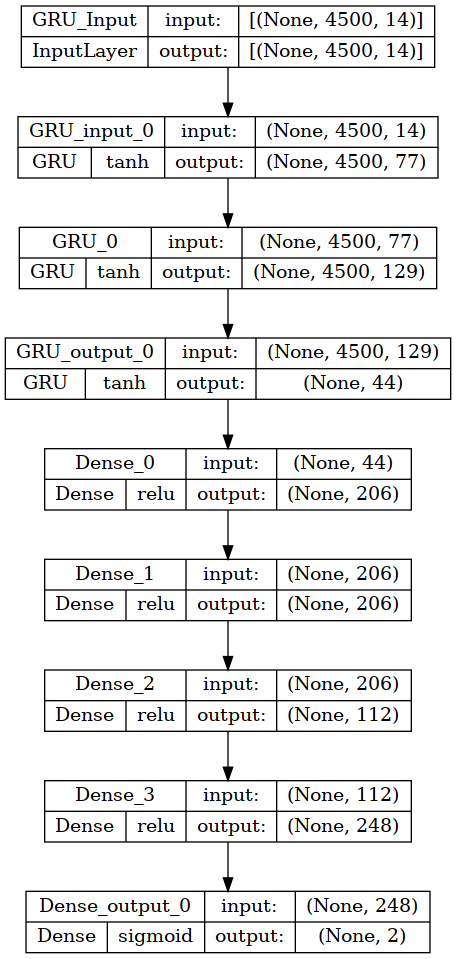

In [11]:
postprocessor.nn_network_plot(
    model_type="GRU",
    to_file="./supporting/anomaly_gru_3d.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
)

Below we plot the confusion matrices for the LSTM and GRU, respectively.

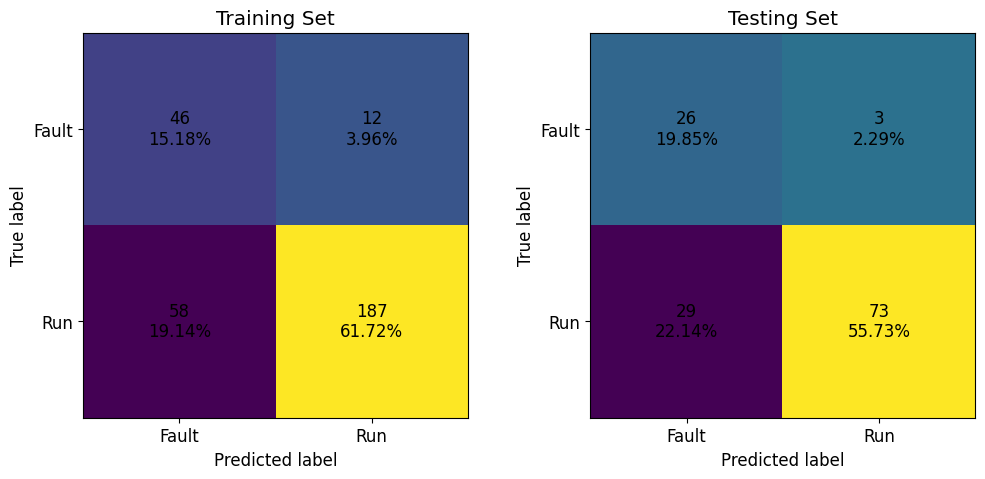

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
postprocessor.confusion_matrix(axs=axs, model_type="LSTM")
plt.show()

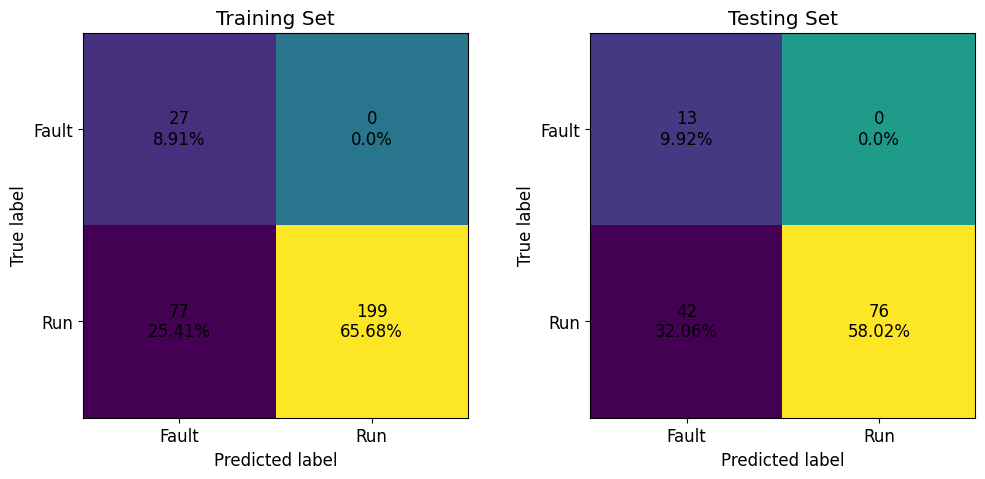

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
postprocessor.confusion_matrix(axs=axs, model_type="GRU")
plt.show()

Both models perform well in identifying the non-faulty waveforms; however, they considerably incorrectly classify the faulty waveforms as non-faulty. This may be a feature of the slight bias of the data to the non-faulty waveforms.

Below are the learning curves for both models.

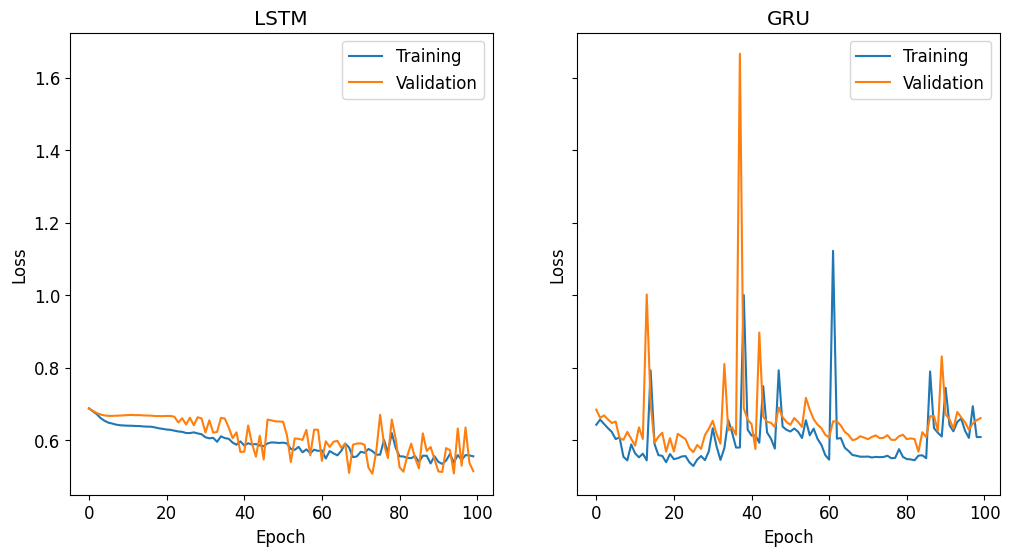

In [14]:
models = np.array([["LSTM", "GRU"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(12,6))
for i in range(models.shape[1]):
    plt.sca(axarr[i])
    axarr[i] = postprocessor.nn_learning_plot(model_type=models[0, i])
    axarr[i].set_title(models[0, i])
plt.show()

We see that minimizing the cross-entropy includes a slight overfitting of the training data for both models. The GRU includes several epochs with sporadically large cross-entropy.

## Case 2: 2D Data

We load the DTL dataset using the `load_anomaly_data` wrapper function implemented in `benchmarks/supporting/anomaly/preprocessing.py`. The shapes of train/test input/output sets are shown below. We then apply a split sequence using the `split_sequence` wrapper with a lookback of 10.

In [15]:
data = load_anomaly_data(
    global_settings=global_settings,
    stack_series=True,
    multiclass=False,
    test_size=anomaly_settings.test_size,
    non_faulty_frac=anomaly_settings.non_faulty_frac,
    timestep_step=1,
)
xtrain, xtest, ytrain, ytest = split_sequences(
    data=data[:-1],
    input_steps=10,
    output_steps=1,
    output_position=0,
)
mai._try_clear()

print(f"xtrain shape: {xtrain.shape}")
print(f"ytrain shape: {ytrain.shape}")
print(f"xtest shape: {xtest.shape}")
print(f"ytest shape: {ytest.shape}")

xtrain shape: (1363491, 10, 14)
ytrain shape: (1363491, 2)
xtest shape: (589491, 10, 14)
ytest shape: (589491, 2)


In [16]:
xtrain

<xarray.DataArray (samples: 1363491, time steps: 10, features: 14)>
array([[[0.60082346, 0.60951364, 0.80324602, ..., 0.50068486,
         0.9574455 , 0.48695529],
        [0.59990656, 0.60887671, 0.80324602, ..., 0.49976614,
         0.95767164, 0.48695526],
        [0.60021222, 0.60951364, 0.80283475, ..., 0.49976614,
         0.95776212, 0.48695505],
        ...,
        [0.57667989, 0.61269808, 0.80242348, ..., 0.50206298,
         0.95776212, 0.48451805],
        [0.55834424, 0.61110586, 0.80489117, ..., 0.50068486,
         0.95798826, 0.4869554 ],
        [0.53542215, 0.60919517, 0.80242348, ..., 0.50114417,
         0.95767164, 0.48451793]],

       [[0.59990656, 0.60887671, 0.80324602, ..., 0.49976614,
         0.95767164, 0.48695526],
        [0.60021222, 0.60951364, 0.80283475, ..., 0.49976614,
         0.95776212, 0.48695505],
        [0.60112906, 0.60823983, 0.80283475, ..., 0.50068486,
         0.95740032, 0.48817363],
...
        [0.60357392, 0.49518961, 0.8061251 , ..., 0.4979288 ,
         0.91887063, 0.51010728],
        [0.60387957, 0.49646524, 0.8061251 , ..., 0.4979288 ,
         0.91873503, 0.50767154],
        [0.60357392, 0.49646524, 0.80571377, ..., 0.49884751,
         0.91814709, 0.50523579]],

       [[0.60387957, 0.49678349, 0.80653638, ..., 0.49884751,
         0.91859931, 0.51254803],
        [0.60418516, 0.49678349, 0.80653638, ..., 0.49976614,
         0.91850889, 0.51497877],
        [0.60357392, 0.49646524, 0.8061251 , ..., 0.49976614,
         0.91850889, 0.51133013],
        ...,
        [0.60387957, 0.49646524, 0.8061251 , ..., 0.4979288 ,
         0.91873503, 0.50767154],
        [0.60357392, 0.49646524, 0.80571377, ..., 0.49884751,
         0.91814709, 0.50523579],
        [0.60418516, 0.49582875, 0.80571377, ..., 0.50068486,
         0.91841841, 0.50889444]]])
Coordinates:
  * samples     (samples) int64 0 1 2 3 4 ... 1363487 1363488 1363489 1363490
  * time steps  (time steps) int64 0 1 2 3 4 5 6 7 8 9
  * features    (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [17]:
ytrain

<xarray.DataArray (samples: 1363491, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])
Coordinates:
  * samples   (samples) int64 0 1 2 3 4 ... 1363487 1363488 1363489 1363490
  * features  (features) object 'Class_Fault' 'Class_Run'

For Case 2, we hyperparameter-tuned the following models:

- Long short-term memory neural network: `LSTM`,
- Gated recurrent unit neural network: `GRU`,
- Convolutional/LSTM neural network: `CNN-LSTM`,

by running `benchmarks/supporting/anomaly/binary_case_2.py`. Below is the convergence plot for the Bayesian search.

![bc2](supporting/anomaly/figs/bc2_convergence.png)

All models perform better in hyperparameter tuning using the data format of Case 2 than Case 1. To postprocess these models, we can load the pickle found at `benchmarks/supporting/anomaly/configs/binary_case_2.pkl`.

In [18]:
with open("supporting/anomaly/configs/binary_case_2.pkl", "rb") as f:
    configs = pickle.load(f)
mai._try_clear()

### Model Postprocessing

With the hyperparameter configurations and data, we can retrain the models on the whole dataset using the `pyMAISE.PostProcessor`. For both models, we increase the epochs from 7 to 30.

In [19]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest),
    model_configs=[configs],
    new_model_settings={
        "LSTM": {"fitting_params": {"epochs": 30}},
        "GRU": {"fitting_params": {"epochs": 30}},
        "CNN-LSTM": {"fitting_params": {"epochs": 30}},
    },
)

Below are the performance metrics for the two models on this classification problem.

In [20]:
postprocessor.metrics().drop("Parameter Configurations", axis=1)

,Model Types,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
10,CNN-LSTM,0.841929,0.841929,0.841929,0.841929,0.805956,0.805956,0.805956,0.805956
3,LSTM,0.843386,0.843386,0.843386,0.843386,0.800153,0.800153,0.800153,0.800153
11,CNN-LSTM,0.844380,0.844380,0.844380,0.844380,0.798574,0.798574,0.798574,0.798574
2,LSTM,0.842965,0.842965,0.842965,0.842965,0.797493,0.797493,0.797493,0.797493
6,GRU,0.841691,0.841691,0.841691,0.841691,0.796277,0.796277,0.796277,0.796277
9,GRU,0.838020,0.838020,0.838020,0.838020,0.796046,0.796046,0.796046,0.796046
8,GRU,0.847015,0.847015,0.847015,0.847015,0.794119,0.794119,0.794119,0.794119
4,LSTM,0.843840,0.843840,0.843840,0.843840,0.793547,0.793547,0.793547,0.793547
1,LSTM,0.841962,0.841962,0.841962,0.841962,0.793001,0.793001,0.793001,0.793001
14,CNN-LSTM,0.840165,0.840165,0.840165,0.840165,0.792638,0.792638,0.792638,0.792638


The LSTM, GRU, and CNN-LSTM all perform within 0.01 test accuracy of each other, showing a higher degree of generalizability to unseen data than the produced in Case 1. Additionally, all metrics are considerably better than Case 1.

Below are the optimal hyperparameter configurations and network plots for the LSTM, GRU, and CNN-LSTM, respectively.

In [21]:
for model in ["LSTM", "GRU", "CNN-LSTM"]:
    postprocessor.print_model(model_type=model)
    print()

Model Type: LSTM
  Structural Hyperparameters
    Layer: LSTM_input_0
      units: 114
    Layer: LSTM_0
      units: 145
      activation: tanh
    Layer: LSTM_output_0
      units: 168
      activation: sigmoid
    Layer: Dense_0
      units: 299
    Layer: Dense_output_0
  Compile/Fitting Hyperparameters
    Adam_learning_rate: 0.00010123356602102984
    Adam_clipnorm: 0.915016200236164
    Adam_clipvalue: 0.3648201326572756
    batch_size: 32
Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_input_0 (LSTM)         (None, 10, 114)           58824     
                                                                 
 LSTM_0 (LSTM)               (None, 10, 145)           150800    
                                                                 
 LSTM_output_0 (LSTM)        (None, 168)               211008    
                                                                 
 Dense_

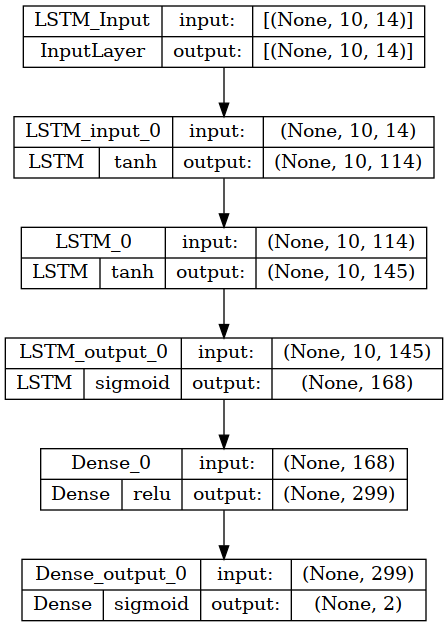

In [22]:
postprocessor.nn_network_plot(
    model_type="LSTM",
    to_file="./supporting/anomaly_lstm_2d.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
)

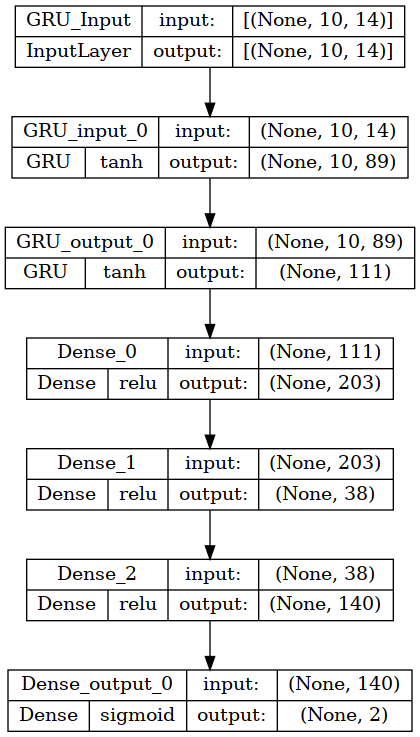

In [23]:
postprocessor.nn_network_plot(
    model_type="GRU",
    to_file="./supporting/anomaly_gru_2d.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
)

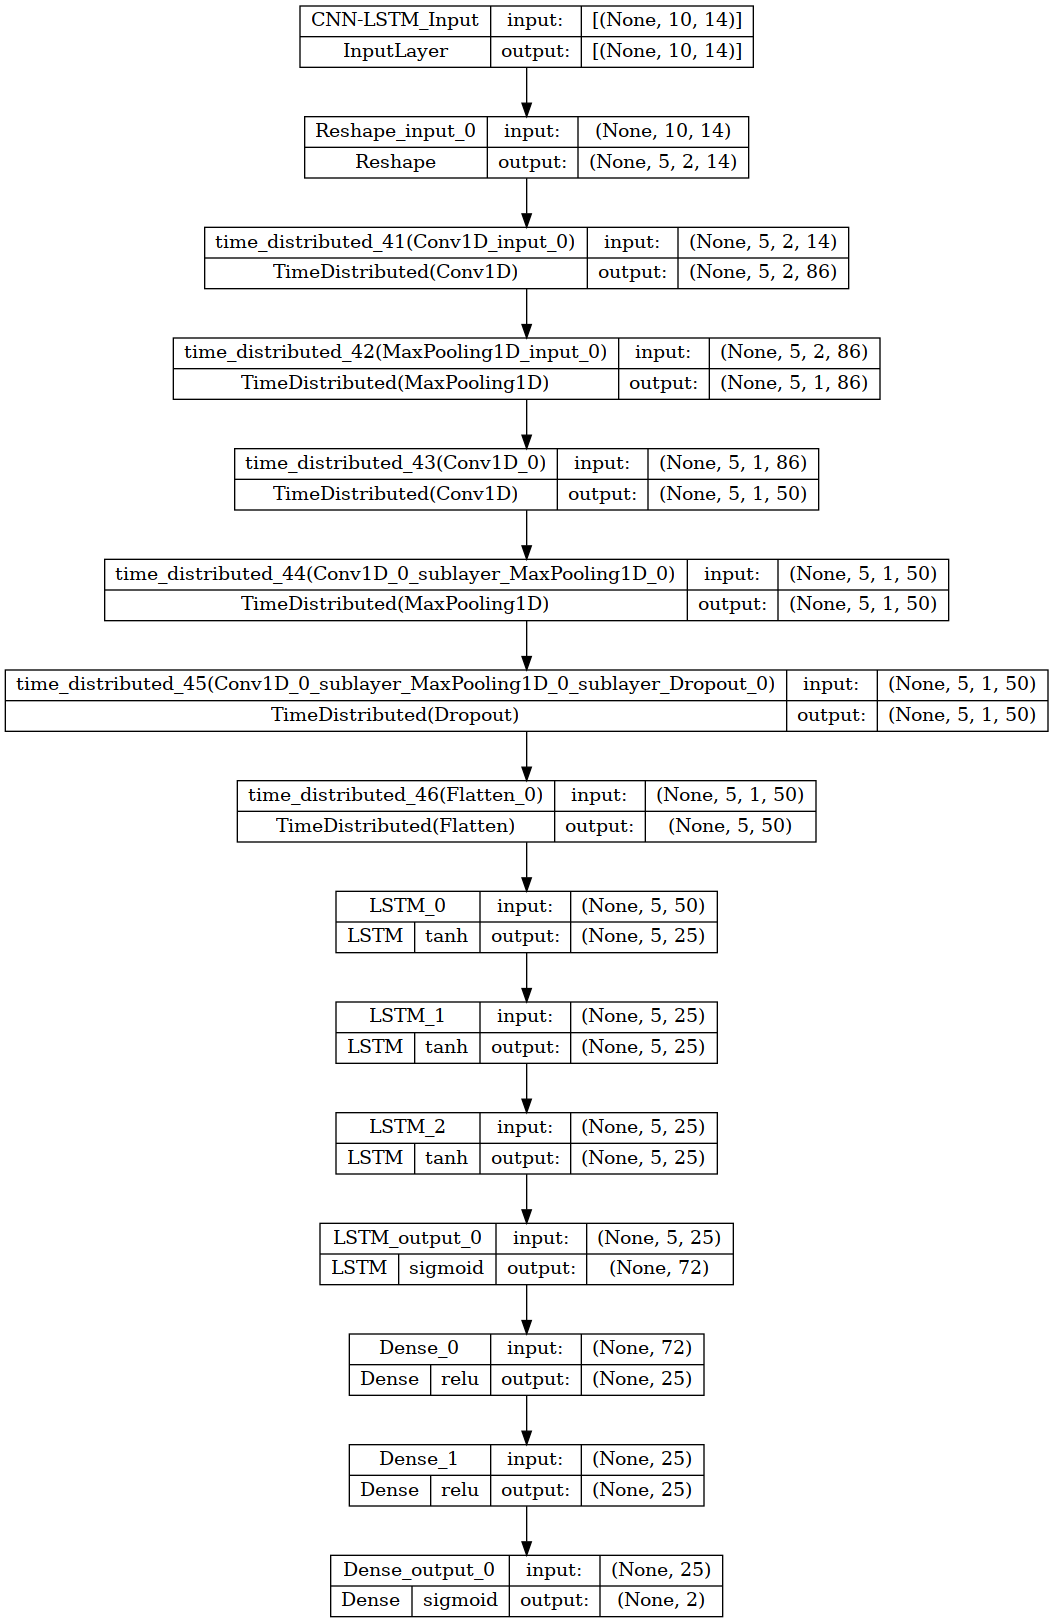

In [24]:
postprocessor.nn_network_plot(
    model_type="CNN-LSTM",
    to_file="./supporting/anomaly_cnnlstm_2d.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
)

Below we plot the confusion matrices for the LSTM, GRU, and CNN-LSTM, respectively.

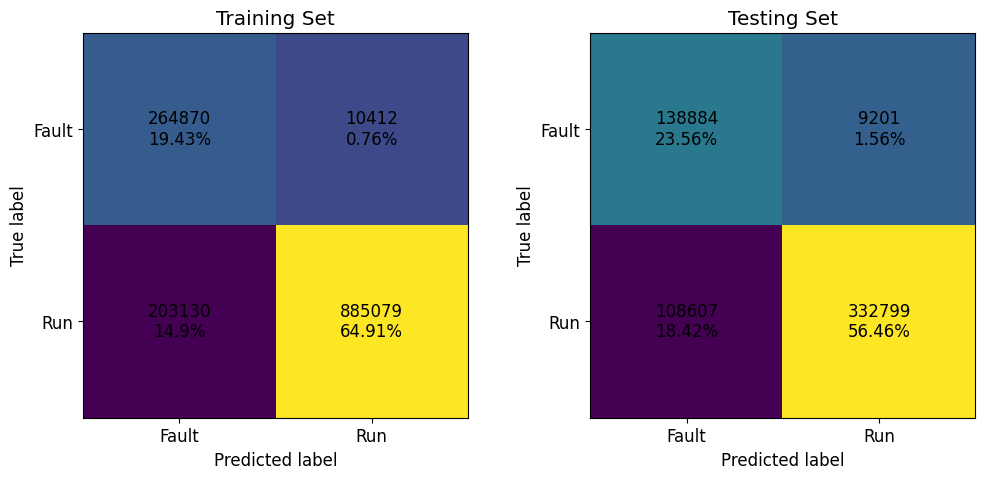

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
postprocessor.confusion_matrix(axs=axs, model_type="LSTM")
plt.show()

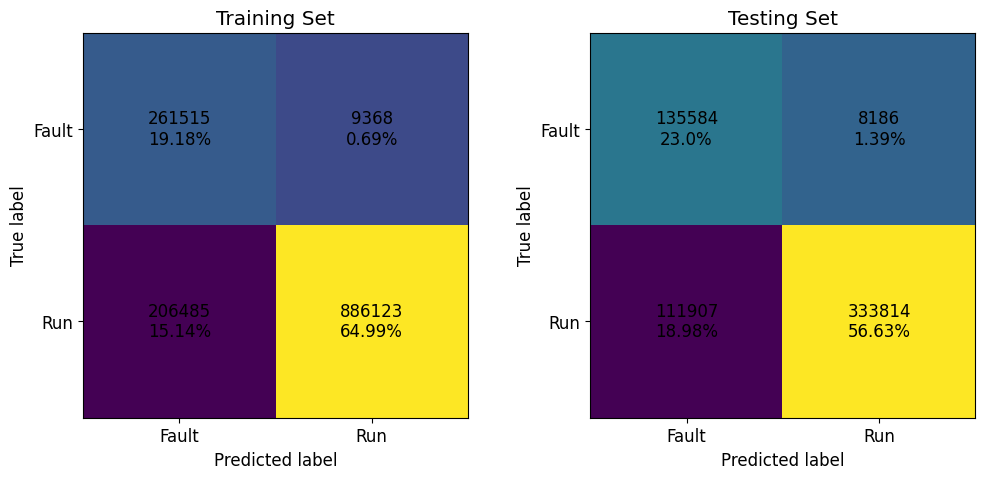

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
postprocessor.confusion_matrix(axs=axs, model_type="GRU")
plt.show()

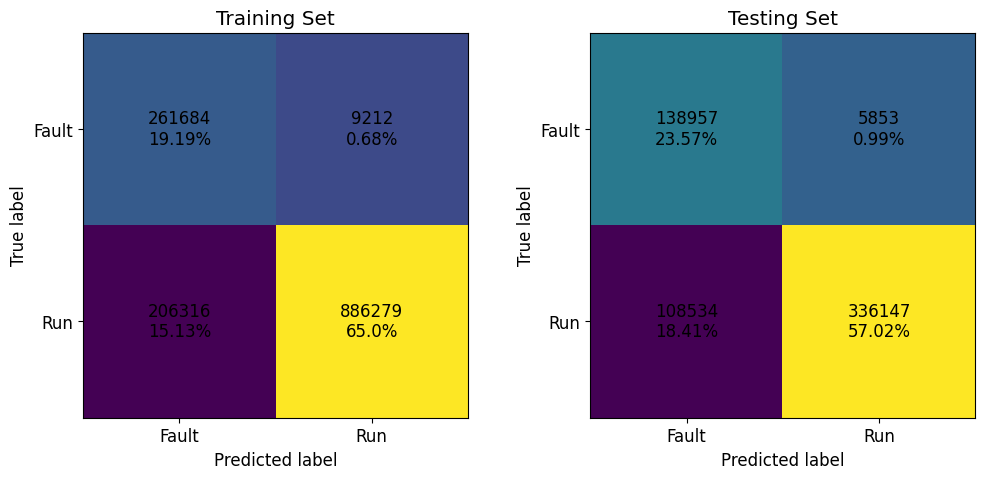

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
postprocessor.confusion_matrix(axs=axs, model_type="CNN-LSTM")
plt.show()

The resulting percentages follow that shown in Case 1; however, the percentage of faulty waveforms misclassified was reduced by more than 5%.

Below are the learning curves.

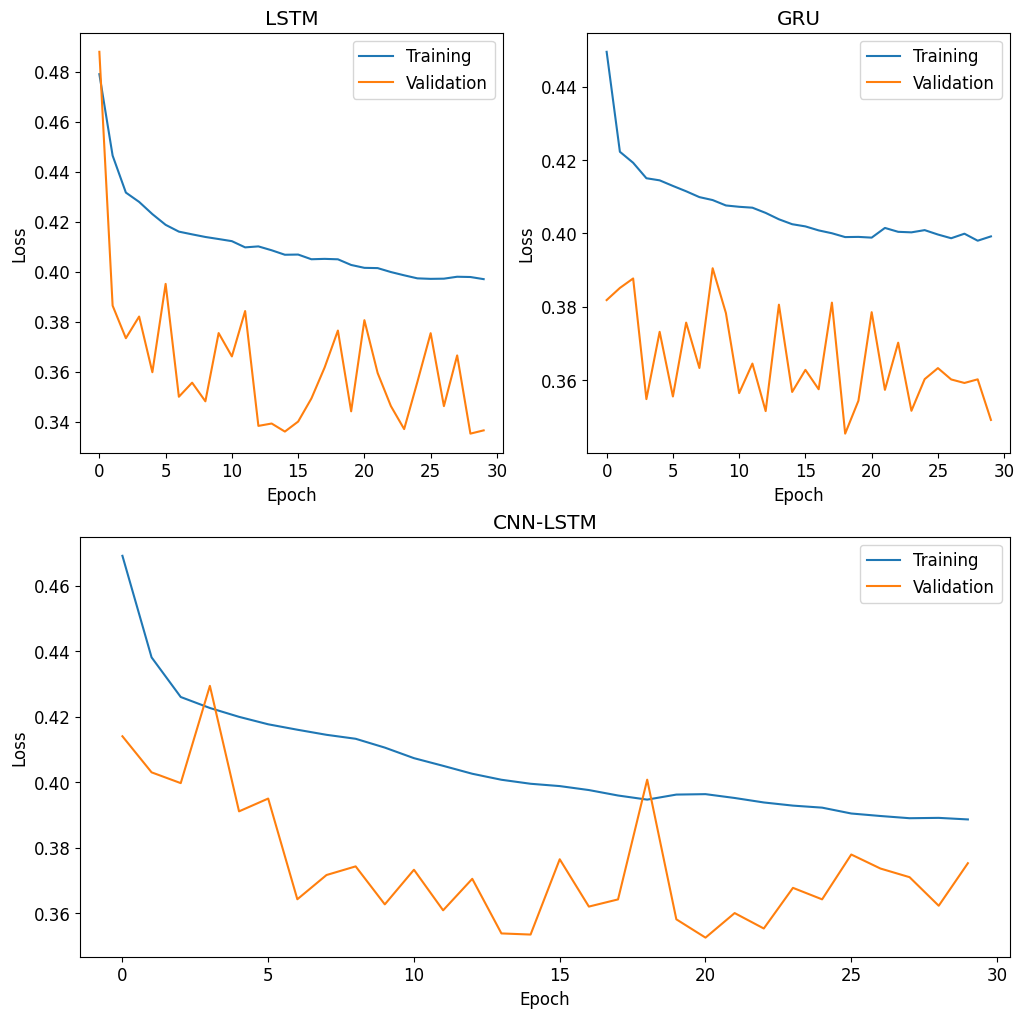

In [28]:
models = np.array([["LSTM", "GRU"]])
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(2, 2)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        ax = postprocessor.nn_learning_plot(model_type=models[i, j])
        ax.set_title(models[i, j])
ax = fig.add_subplot(gs[1, :])
ax = postprocessor.nn_learning_plot(model_type="CNN-LSTM")
ax.set_title("CNN-LSTM")
plt.show()

The learning curves for all three models indicate they are not overfitting the training set. Additionally, their convergence is much more predictable.

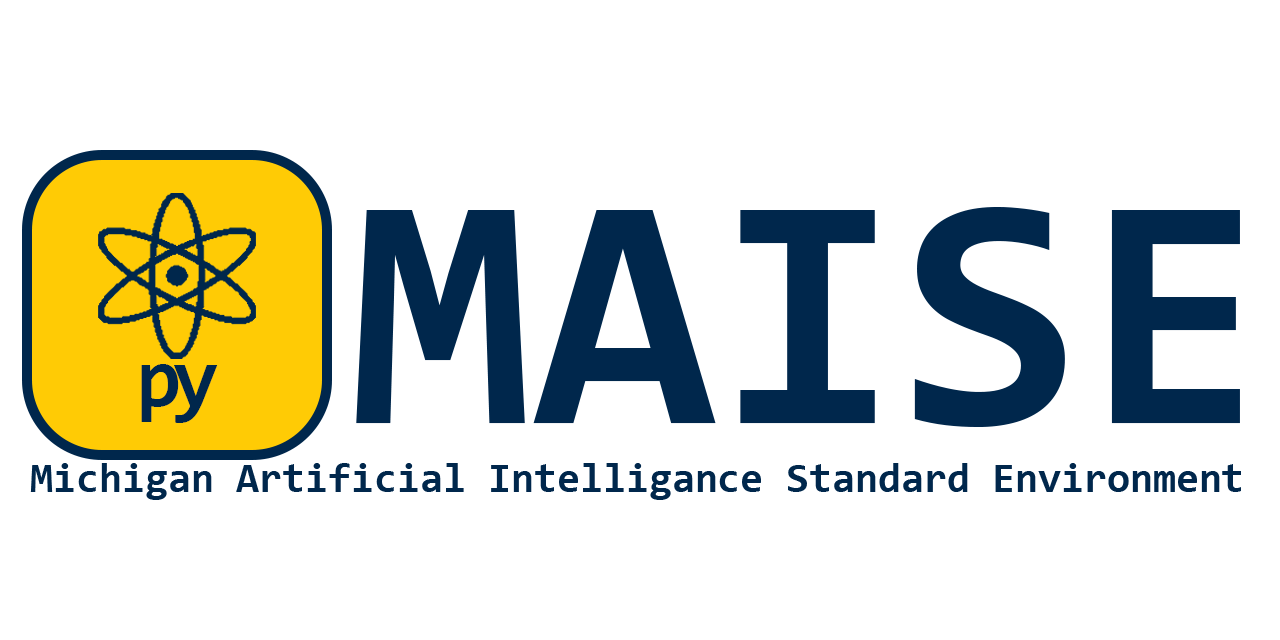